In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, \
                                    Flatten, Conv1D, MaxPooling1D, Dropout, \
                                    Concatenate, GlobalMaxPool1D, GlobalAvgPool1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_cnn(conv_num=1):
    filter_size = 128

    input_layer = Input(shape=input_shape)
    x = input_layer

    layer_outputs = []
    for i in range(conv_num):
        x = Conv1D (kernel_size=5, filters=filter_size*(2**(i//4)), 
                          strides=1, padding='same')(x)
        x = Activation('relu')(x)
        x = MaxPooling1D(pool_size=3, strides=3)(x)
        layer_outputs.append(x)    
    
    x = Concatenate()([Flatten()(output) for output in layer_outputs[-2:]])
    x = Dropout(0.5)(x)
    x = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=x)
    return model

In [9]:
for i in range(3, 9):
    model = build_cnn(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 16000, 128)   768         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 16000, 128)   0           conv1d[0][0]                     
__________________________________________________________________________________________________
max_pooling1d (MaxPoo

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 16000, 128)   768         input_3[0][0]                    
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 16000, 128)   0           conv1d_7[0][0]                   
__________________________________________________________________________________________________
max_pooling1d_7 (MaxPooling1D)  (None, 5333, 128)    0           activation_7[0][0]               
__________________________________________________________________________________________________
conv1d_8 (

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 16000, 128)   768         input_5[0][0]                    
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 16000, 128)   0           conv1d_18[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_18 (MaxPooling1D) (None, 5333, 128)    0           activation_18[0][0]              
__________________________________________________________________________________________________
conv1d_19 

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8505 - acc: 0.4119
Epoch 00001: val_loss improved from inf to 1.45276, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_128_DO_4_conv_checkpoint/001-1.4528.hdf5
36805/36805 [==============================] - 66s 2ms/sample - loss: 1.8506 - acc: 0.4119 - val_loss: 1.4528 - val_acc: 0.5611
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2953 - acc: 0.5995
Epoch 00002: val_loss improved from 1.45276 to 1.17405, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_128_DO_4_conv_checkpoint/002-1.1740.hdf5
36805/36805 [==============================] - 64s 2ms/sample - loss: 1.2952 - acc: 0.5995 - val_loss: 1.1740 - val_acc: 0.6396
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0903 - acc: 0.6684
Epoch 00003: val_loss improved from 1.1

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0781 - acc: 0.9765
Epoch 00027: val_loss did not improve from 0.88482
36805/36805 [==============================] - 63s 2ms/sample - loss: 0.0781 - acc: 0.9766 - val_loss: 1.2004 - val_acc: 0.7643
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0732 - acc: 0.9785
Epoch 00028: val_loss did not improve from 0.88482
36805/36805 [==============================] - 63s 2ms/sample - loss: 0.0732 - acc: 0.9785 - val_loss: 1.2471 - val_acc: 0.7636
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0679 - acc: 0.9808
Epoch 00029: val_loss did not improve from 0.88482
36805/36805 [==============================] - 63s 2ms/sample - loss: 0.0679 - acc: 0.9808 - val_loss: 1.2934 - val_acc: 0.7603
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0695 - acc: 0.9796
Epoch 00030: val_loss did not improve from 0.88482
36805/36805 [===========

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0368 - acc: 0.9906
Epoch 00057: val_loss did not improve from 0.88482
36805/36805 [==============================] - 63s 2ms/sample - loss: 0.0368 - acc: 0.9906 - val_loss: 1.4565 - val_acc: 0.7720
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0335 - acc: 0.9914
Epoch 00058: val_loss did not improve from 0.88482
36805/36805 [==============================] - 63s 2ms/sample - loss: 0.0335 - acc: 0.9914 - val_loss: 1.3831 - val_acc: 0.7834
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0364 - acc: 0.9906
Epoch 00059: val_loss did not improve from 0.88482
36805/36805 [==============================] - 63s 2ms/sample - loss: 0.0364 - acc: 0.9906 - val_loss: 1.3629 - val_acc: 0.7873

1D_CNN_custom_multi_2_concat_ch_128_DO_4_conv Model


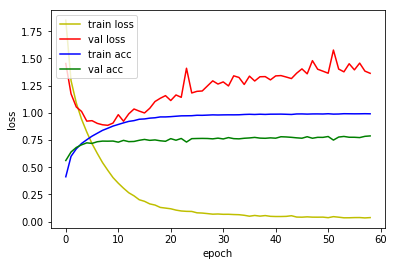

4815/4815 [==============================] - 3s 711us/sample - loss: 0.9640 - acc: 0.7130
Loss: 0.9640262068493963 Accuracy: 0.7129803

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9111 - acc: 0.3802
Epoch 00001: val_loss improved from inf to 1.40263, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_128_DO_5_conv_checkpoint/001-1.4026.hdf5
36805/36805 [==============================] - 66s 2ms/sample - loss: 1.9112 - acc: 0.3802 - val_loss: 1.4026 - val_acc: 0.5751
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3244 - acc: 0.5904
Epoch 00002: val_loss improved from 1.40263 to 1.12327, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_128_DO_5_conv_checkpoint/002-1.1233.hdf5
36805/36805 [==============================] - 64s 2ms/sample - loss: 1.3243 - acc: 0.5904 - val_loss: 1.1233 - val_acc: 0.6629
Epoch 3/500
36800/36805 [======================

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1158 - acc: 0.9638
Epoch 00025: val_loss did not improve from 0.49546
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.1159 - acc: 0.9638 - val_loss: 0.6123 - val_acc: 0.8584
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1096 - acc: 0.9658
Epoch 00026: val_loss did not improve from 0.49546
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.1096 - acc: 0.9658 - val_loss: 0.5584 - val_acc: 0.8693
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1004 - acc: 0.9687
Epoch 00027: val_loss did not improve from 0.49546
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.1004 - acc: 0.9687 - val_loss: 0.5559 - val_acc: 0.8789
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0978 - acc: 0.9689
Epoch 00028: val_loss did not improve from 0.49546
36805/36805 [===========

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0389 - acc: 0.9890
Epoch 00055: val_loss did not improve from 0.49546
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.0389 - acc: 0.9890 - val_loss: 0.6447 - val_acc: 0.8786
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0426 - acc: 0.9878
Epoch 00056: val_loss did not improve from 0.49546
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.0426 - acc: 0.9878 - val_loss: 0.6006 - val_acc: 0.8861
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0362 - acc: 0.9902
Epoch 00057: val_loss did not improve from 0.49546
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.0363 - acc: 0.9901 - val_loss: 0.6631 - val_acc: 0.8810
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0389 - acc: 0.9890
Epoch 00058: val_loss did not improve from 0.49546
36805/36805 [===========

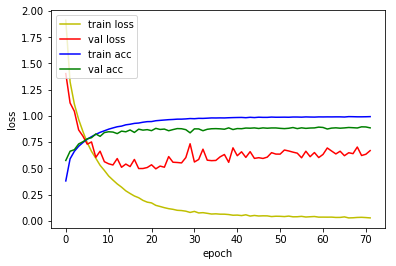

4815/4815 [==============================] - 3s 717us/sample - loss: 0.6069 - acc: 0.8474
Loss: 0.6069400324380781 Accuracy: 0.847352

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9476 - acc: 0.3682
Epoch 00001: val_loss improved from inf to 1.33270, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_128_DO_6_conv_checkpoint/001-1.3327.hdf5
36805/36805 [==============================] - 67s 2ms/sample - loss: 1.9477 - acc: 0.3682 - val_loss: 1.3327 - val_acc: 0.5756
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2604 - acc: 0.6050
Epoch 00002: val_loss improved from 1.33270 to 0.98248, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_128_DO_6_conv_checkpoint/002-0.9825.hdf5
36805/36805 [==============================] - 65s 2ms/sample - loss: 1.2602 - acc: 0.6051 - val_loss: 0.9825 - val_acc: 0.7093
Epoch 3/500
36800/36805 [=======================

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1255 - acc: 0.9579
Epoch 00024: val_loss improved from 0.26127 to 0.25547, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_128_DO_6_conv_checkpoint/024-0.2555.hdf5
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.1254 - acc: 0.9579 - val_loss: 0.2555 - val_acc: 0.9317
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1146 - acc: 0.9636
Epoch 00025: val_loss did not improve from 0.25547
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.1146 - acc: 0.9636 - val_loss: 0.2577 - val_acc: 0.9366
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1076 - acc: 0.9646
Epoch 00026: val_loss did not improve from 0.25547
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.1076 - acc: 0.9646 - val_loss: 0.2631 - val_acc: 0.9364
Epoch 27/500
36800/36805 [============================>.] - E

36800/36805 [============================>.] - ETA: 0s - loss: 0.0323 - acc: 0.9897
Epoch 00053: val_loss did not improve from 0.25547
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0323 - acc: 0.9897 - val_loss: 0.3507 - val_acc: 0.9338
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0326 - acc: 0.9902
Epoch 00054: val_loss did not improve from 0.25547
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0326 - acc: 0.9902 - val_loss: 0.3142 - val_acc: 0.9369
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0317 - acc: 0.9900
Epoch 00055: val_loss did not improve from 0.25547
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0317 - acc: 0.9900 - val_loss: 0.3020 - val_acc: 0.9362
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0344 - acc: 0.9889
Epoch 00056: val_loss did not improve from 0.25547
36805/36805 [========================

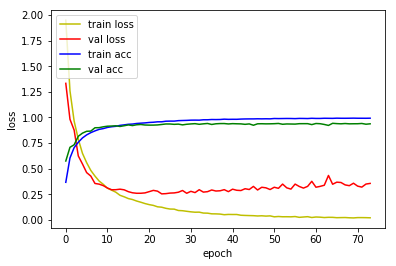

4815/4815 [==============================] - 3s 725us/sample - loss: 0.3025 - acc: 0.9155
Loss: 0.302481050196714 Accuracy: 0.9154725

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9474 - acc: 0.3665
Epoch 00001: val_loss improved from inf to 1.10666, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_128_DO_7_conv_checkpoint/001-1.1067.hdf5
36805/36805 [==============================] - 68s 2ms/sample - loss: 1.9472 - acc: 0.3666 - val_loss: 1.1067 - val_acc: 0.6483
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0383 - acc: 0.6690
Epoch 00002: val_loss improved from 1.10666 to 0.70650, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_128_DO_7_conv_checkpoint/002-0.7065.hdf5
36805/36805 [==============================] - 65s 2ms/sample - loss: 1.0383 - acc: 0.6690 - val_loss: 0.7065 - val_acc: 0.7855
Epoch 3/500
36800/36805 [=======================

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0837 - acc: 0.9721
Epoch 00025: val_loss did not improve from 0.14368
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0837 - acc: 0.9721 - val_loss: 0.1730 - val_acc: 0.9509
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0810 - acc: 0.9721
Epoch 00026: val_loss did not improve from 0.14368
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0810 - acc: 0.9720 - val_loss: 0.1677 - val_acc: 0.9564
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0765 - acc: 0.9734
Epoch 00027: val_loss did not improve from 0.14368
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0765 - acc: 0.9734 - val_loss: 0.1580 - val_acc: 0.9536
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0749 - acc: 0.9742
Epoch 00028: val_loss did not improve from 0.14368
36805/36805 [===========

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0255 - acc: 0.9912
Epoch 00055: val_loss did not improve from 0.14368
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0255 - acc: 0.9912 - val_loss: 0.1716 - val_acc: 0.9644
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0217 - acc: 0.9928
Epoch 00056: val_loss did not improve from 0.14368
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0217 - acc: 0.9928 - val_loss: 0.2190 - val_acc: 0.9590
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0234 - acc: 0.9921
Epoch 00057: val_loss did not improve from 0.14368
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0234 - acc: 0.9921 - val_loss: 0.1758 - val_acc: 0.9632
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0236 - acc: 0.9923
Epoch 00058: val_loss did not improve from 0.14368
36805/36805 [===========

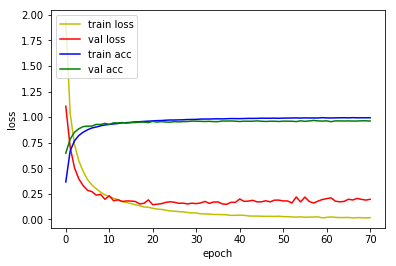

4815/4815 [==============================] - 4s 753us/sample - loss: 0.1918 - acc: 0.9456
Loss: 0.19176398669509748 Accuracy: 0.9455867

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7234 - acc: 0.4395
Epoch 00001: val_loss improved from inf to 0.89131, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_128_DO_8_conv_checkpoint/001-0.8913.hdf5
36805/36805 [==============================] - 70s 2ms/sample - loss: 1.7232 - acc: 0.4396 - val_loss: 0.8913 - val_acc: 0.7154
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8379 - acc: 0.7289
Epoch 00002: val_loss improved from 0.89131 to 0.56734, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_128_DO_8_conv_checkpoint/002-0.5673.hdf5
36805/36805 [==============================] - 66s 2ms/sample - loss: 0.8378 - acc: 0.7289 - val_loss: 0.5673 - val_acc: 0.8262
Epoch 3/500
36800/36805 [=====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0683 - acc: 0.9779
Epoch 00025: val_loss did not improve from 0.13934
36805/36805 [==============================] - 66s 2ms/sample - loss: 0.0683 - acc: 0.9779 - val_loss: 0.1468 - val_acc: 0.9604
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0563 - acc: 0.9807
Epoch 00026: val_loss did not improve from 0.13934
36805/36805 [==============================] - 66s 2ms/sample - loss: 0.0563 - acc: 0.9807 - val_loss: 0.1764 - val_acc: 0.9515
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0571 - acc: 0.9806
Epoch 00027: val_loss did not improve from 0.13934
36805/36805 [==============================] - 66s 2ms/sample - loss: 0.0571 - acc: 0.9806 - val_loss: 0.1805 - val_acc: 0.9478
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0530 - acc: 0.9823
Epoch 00028: val_loss improved from 0.13934 to 0.13818, saving model to model/checkpoint

36800/36805 [============================>.] - ETA: 0s - loss: 0.0202 - acc: 0.9930
Epoch 00054: val_loss did not improve from 0.13818
36805/36805 [==============================] - 66s 2ms/sample - loss: 0.0202 - acc: 0.9930 - val_loss: 0.2242 - val_acc: 0.9606
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0188 - acc: 0.9940
Epoch 00055: val_loss did not improve from 0.13818
36805/36805 [==============================] - 66s 2ms/sample - loss: 0.0187 - acc: 0.9940 - val_loss: 0.2295 - val_acc: 0.9588
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0175 - acc: 0.9943
Epoch 00056: val_loss did not improve from 0.13818
36805/36805 [==============================] - 66s 2ms/sample - loss: 0.0175 - acc: 0.9943 - val_loss: 0.2296 - val_acc: 0.9595
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0205 - acc: 0.9935
Epoch 00057: val_loss did not improve from 0.13818
36805/36805 [========================

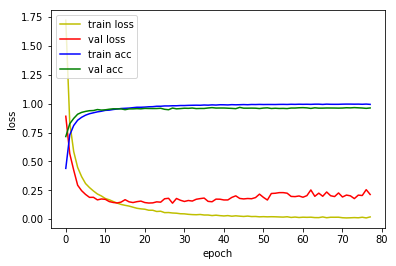

4815/4815 [==============================] - 4s 762us/sample - loss: 0.1959 - acc: 0.9479
Loss: 0.19594085773903788 Accuracy: 0.9478712



In [10]:
base = '1D_CNN_custom_multi_2_concat_ch_128_DO'

for i in range(4, 9):
    model_name = base+'_{}_conv'.format(i)
    model = build_cnn(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_multi_2_concat_ch_128_DO'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(4, 9):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_2_concat_ch_128_DO_4_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 128)   768         input_7[0][0]                    
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 128)   0           conv1d_33[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_33 (MaxPooling1D) (None, 5333, 128)    0           activation_33[0][0]              
________________________________________________________

4815/4815 [==============================] - 4s 750us/sample - loss: 0.6069 - acc: 0.8474
Loss: 0.6069400324380781 Accuracy: 0.847352

1D_CNN_custom_multi_2_concat_ch_128_DO_6_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_42 (Conv1D)              (None, 16000, 128)   768         input_9[0][0]                    
__________________________________________________________________________________________________
activation_42 (Activation)      (None, 16000, 128)   0           conv1d_42[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_42 (Max

4815/4815 [==============================] - 4s 779us/sample - loss: 0.1918 - acc: 0.9456
Loss: 0.19176398669509748 Accuracy: 0.9455867

1D_CNN_custom_multi_2_concat_ch_128_DO_8_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_55 (Conv1D)              (None, 16000, 128)   768         input_11[0][0]                   
__________________________________________________________________________________________________
activation_55 (Activation)      (None, 16000, 128)   0           conv1d_55[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_55 (M

In [12]:
for i in range(4, 9):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_custom_multi_2_concat_ch_128_DO_4_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 128)   768         input_7[0][0]                    
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 128)   0           conv1d_33[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_33 (MaxPooling1D) (None, 5333, 128)    0           activation_33[0][0]              
________________________________________________________

4815/4815 [==============================] - 4s 776us/sample - loss: 0.8642 - acc: 0.8596
Loss: 0.8641717162087699 Accuracy: 0.8596054

1D_CNN_custom_multi_2_concat_ch_128_DO_6_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_42 (Conv1D)              (None, 16000, 128)   768         input_9[0][0]                    
__________________________________________________________________________________________________
activation_42 (Activation)      (None, 16000, 128)   0           conv1d_42[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_42 (Ma

4815/4815 [==============================] - 4s 834us/sample - loss: 0.2516 - acc: 0.9518
Loss: 0.25164901005074686 Accuracy: 0.9518172

1D_CNN_custom_multi_2_concat_ch_128_DO_8_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_55 (Conv1D)              (None, 16000, 128)   768         input_11[0][0]                   
__________________________________________________________________________________________________
activation_55 (Activation)      (None, 16000, 128)   0           conv1d_55[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_55 (M